In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pylab as plt
import time
from matplotlib import animation, rc
from IPython.display import HTML

In [49]:
field_size = 102
hidden_size = 8
epochs = 10
batch_size = 32
model_name = 'models/first_model'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
class GruCell(nn.Module):
    def __init__(self, hidden_size = 10):
        super(GruCell, self).__init__()
        self.my_reset = nn.Linear(hidden_size, hidden_size)
        self.my_update = nn.Linear(hidden_size, hidden_size)
        self.my_final = nn.Linear(hidden_size, hidden_size)
        self.neighbours_reset = nn.Linear(4 * hidden_size, hidden_size)
        self.neighbours_update = nn.Linear(4 * hidden_size, hidden_size)
        self.neighbours_final = nn.Linear(4 * hidden_size, hidden_size)

    def forward(self, state, x):
        reset_chooser = torch.sigmoid(self.my_reset(state) + self.neighbours_reset(x))
        resetted = reset_chooser * state
        update_chooser = torch.sigmoid(self.my_update(state) + self.neighbours_update(x))
        update = torch.tanh(self.my_final(resetted) + self.neighbours_final(x))
        update = update_chooser * update
        new_state = (1 - update_chooser) * state + update
        return reset_chooser, update_chooser, update, new_state

In [51]:
net = GruCell(hidden_size)
net.eval()
net.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [52]:
net.to(device)

GruCell(
  (my_reset): Linear(in_features=8, out_features=8, bias=True)
  (my_update): Linear(in_features=8, out_features=8, bias=True)
  (my_final): Linear(in_features=8, out_features=8, bias=True)
  (neighbours_reset): Linear(in_features=32, out_features=8, bias=True)
  (neighbours_update): Linear(in_features=32, out_features=8, bias=True)
  (neighbours_final): Linear(in_features=32, out_features=8, bias=True)
)

In [69]:
def init():
    global field
    field = torch.randn(field_size, field_size, hidden_size)
    # зануляем края
    for i in range(field_size):
        for j in range(field_size):
            if i == 0 or j == 0 or i == field_size - 1 or j == field_size - 1:
                field[i, j] = torch.zeros(hidden_size)



In [70]:
#fig, ax = plt.subplots(figsize=(10,10))   
#ax = sns.heatmap(torch.mean(field ** 2, axis = 2), ax=ax, square=True)
#plt.show()

In [67]:
def animate(e):
    global field
    global ax
    pump_energy = False
    # накачивать ли рандомом
    # тот же самый цикл, но без обучения
    with torch.no_grad():
    #for e in range(epochs):
        new_field = torch.zeros(field_size, field_size, hidden_size)
        train_set = []
        for i in range(1, field_size - 1):
            for j in range(1, field_size - 1):
                tmp = []
                tmp.append(field[i, j].to(device))
                # верхние и боковые соседи
                tmp.append(torch.cat([field[i - 1, j], field[i + 1, j], field[i, j - 1], field[i, j + 1]]).to(device))
                # координаты поля
                tmp.append((i, j))
                train_set.append(tmp)


        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0)
        for cells, neighbours, cords in train_loader:
            loc_y, loc_x = cords
            reset, update, delta, state = net(cells, neighbours)
            for new_state, y, x in zip(state, loc_y, loc_x):
                new_field[y, x] = new_state
            # print statistics
        mean_information = torch.mean(field ** 2)
        field = new_field.clone()
        print(f'[{e + 1}]; Mean Information : {torch.mean(field ** 2)}')
        plt.clf()
        if pump_energy:
            field += torch.randn(field_size, field_size, hidden_size)
            sns.heatmap(torch.mean(field ** 2, axis = 2), ax=ax, square=True)
        else:
            #field += torch.randn(field_size, field_size, hidden_size)
            #если не накачивать рандомом, то значения колеблются от 0 до 4
            sns.heatmap(torch.mean(field ** 2, axis = 2), ax=ax, square=True, vmin = 0, vmax = 2, cbar=False)

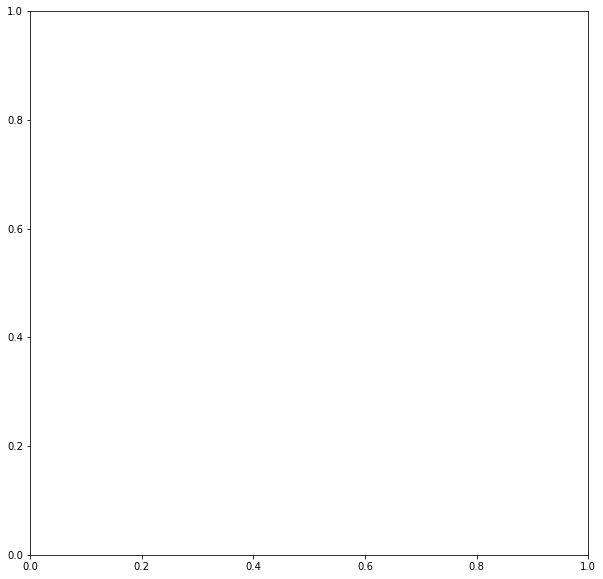

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10, interval=1, blit=False)

In [75]:
#HTML(anim.to_html5_video())
# надо перезапускать сначала, чтобы поле переинициализировать

In [77]:
anim.save('animations/anim_2.gif', writer='imagemagick', fps=2)

MovieWriter imagemagick unavailable; using Pillow instead.


[1]; Mean Information : 0.4601840078830719
[2]; Mean Information : 0.43196529150009155
[3]; Mean Information : 0.5523274540901184
[4]; Mean Information : 0.7048530578613281
[5]; Mean Information : 0.8166463375091553
[6]; Mean Information : 0.8753125667572021
[7]; Mean Information : 0.8977521061897278
[8]; Mean Information : 0.9040918946266174
[9]; Mean Information : 0.9055777192115784
[10]; Mean Information : 0.9058724641799927


<Figure size 432x288 with 0 Axes>